# 관측 자료의 관측값  EDA

In [1]:
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_list = glob.glob('../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료/*vaisala*.csv')

df = pd.read_csv(df_list[1])

In [3]:
df_list[1].split('\\')[-1].split('_')

['seoul', '2', 'naebu', 'vaisala', '20230119', 'U.csv']

In [4]:
road_name = df_list[1].split('\\')[-1].split('_')[2]
obs_time = df_list[1].split('\\')[-1].split('_')[-2]
road_dir = df_list[1].split('\\')[-1].split('_')[-1].split('.')[0]

In [5]:
print(road_name,obs_time,road_dir)

naebu 20230119 U


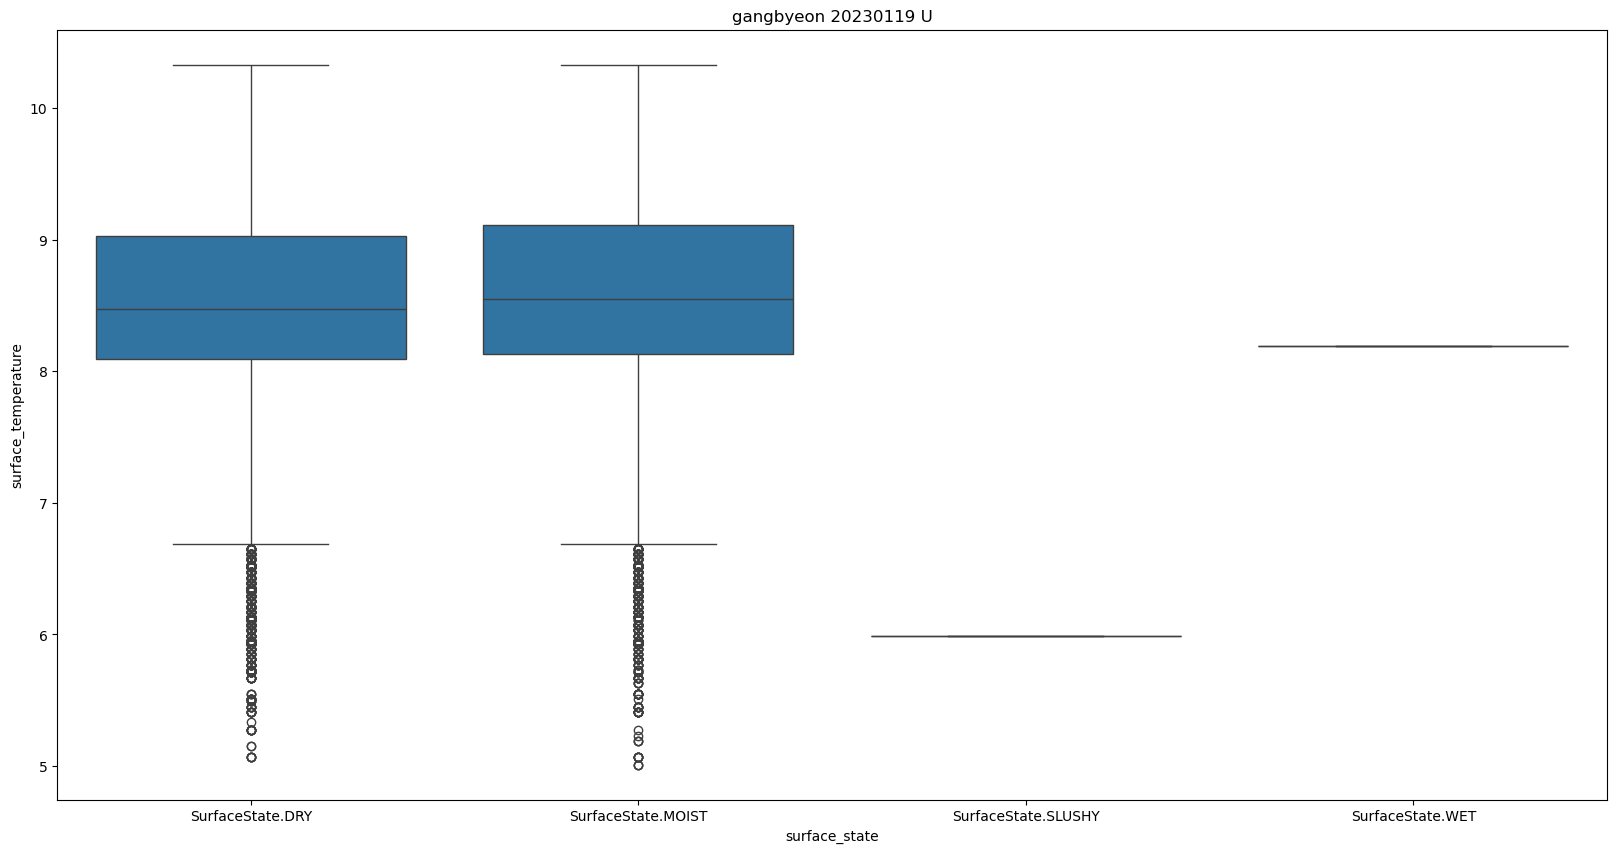

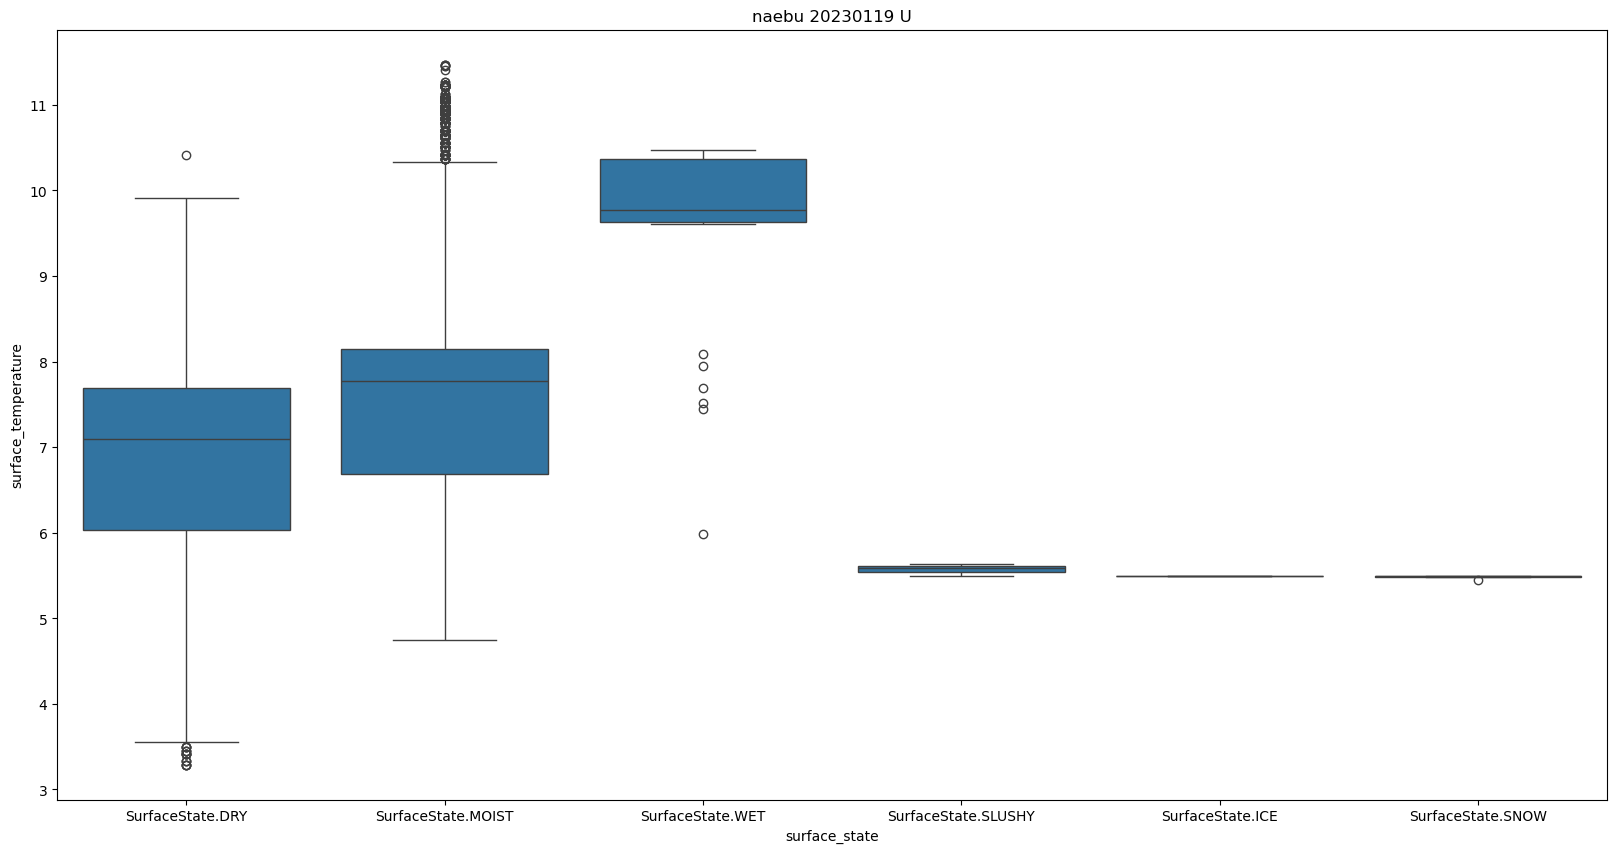

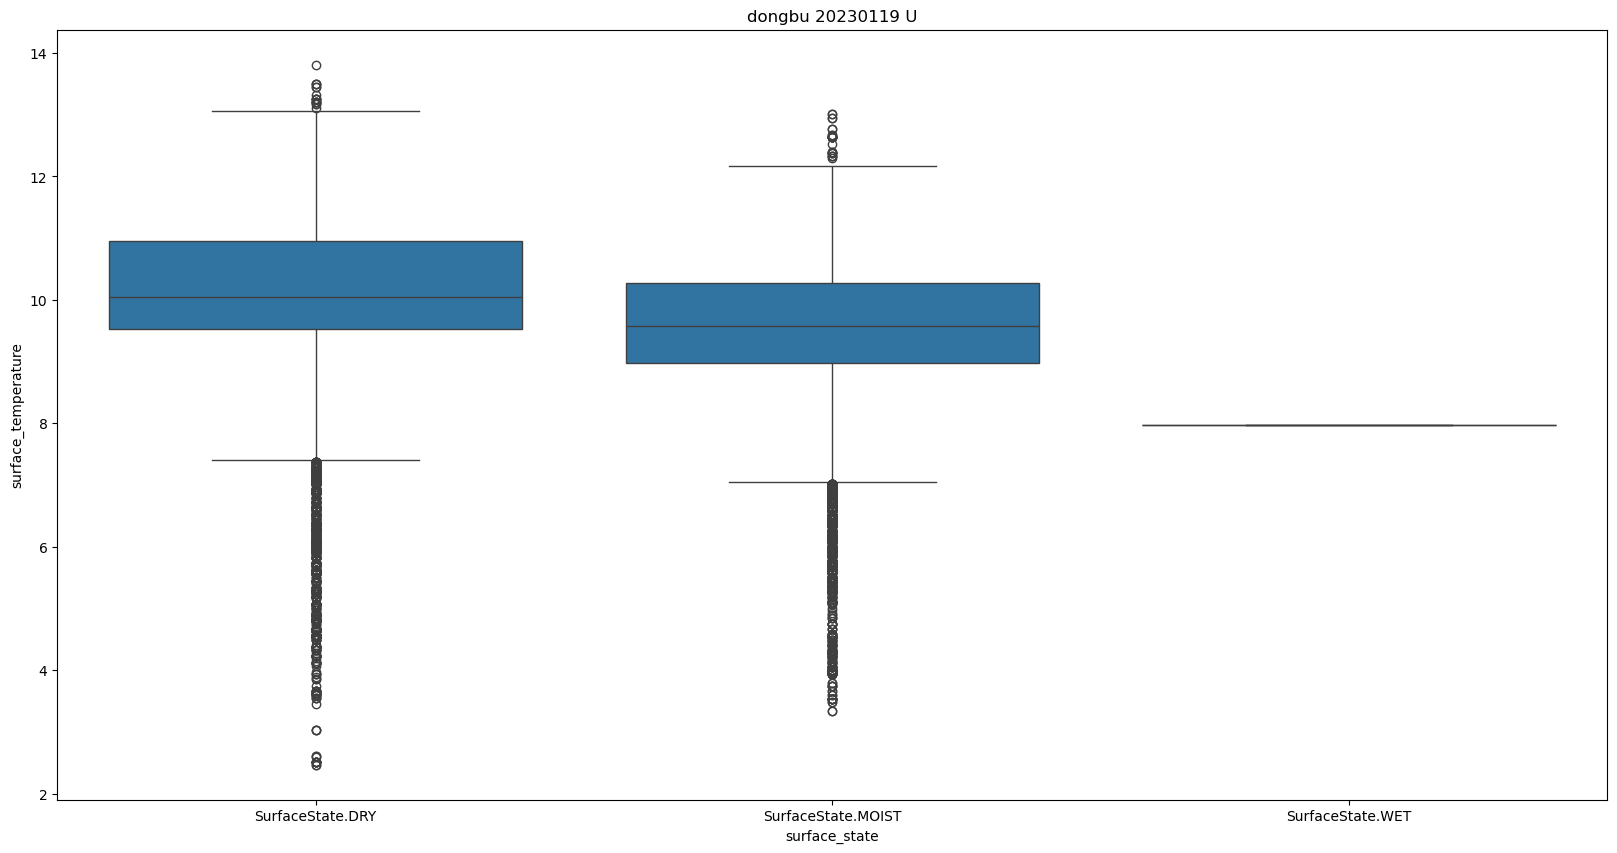

In [7]:
df_list = glob.glob('../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료/*vaisala*.csv')
for i in df_list:
    df = pd.read_csv(i)
    road_name = i.split('\\')[-1].split('_')[2]
    obs_time = i.split('\\')[-1].split('_')[-2]
    road_dir = i.split('\\')[-1].split('_')[-1].split('.')[0]
    plt.figure(figsize=(20,10))
    sns.boxplot(data = df, x = 'surface_state', y = 'surface_temperature')
    plt.title(f'{road_name} {obs_time} {road_dir}')
    plt.show()

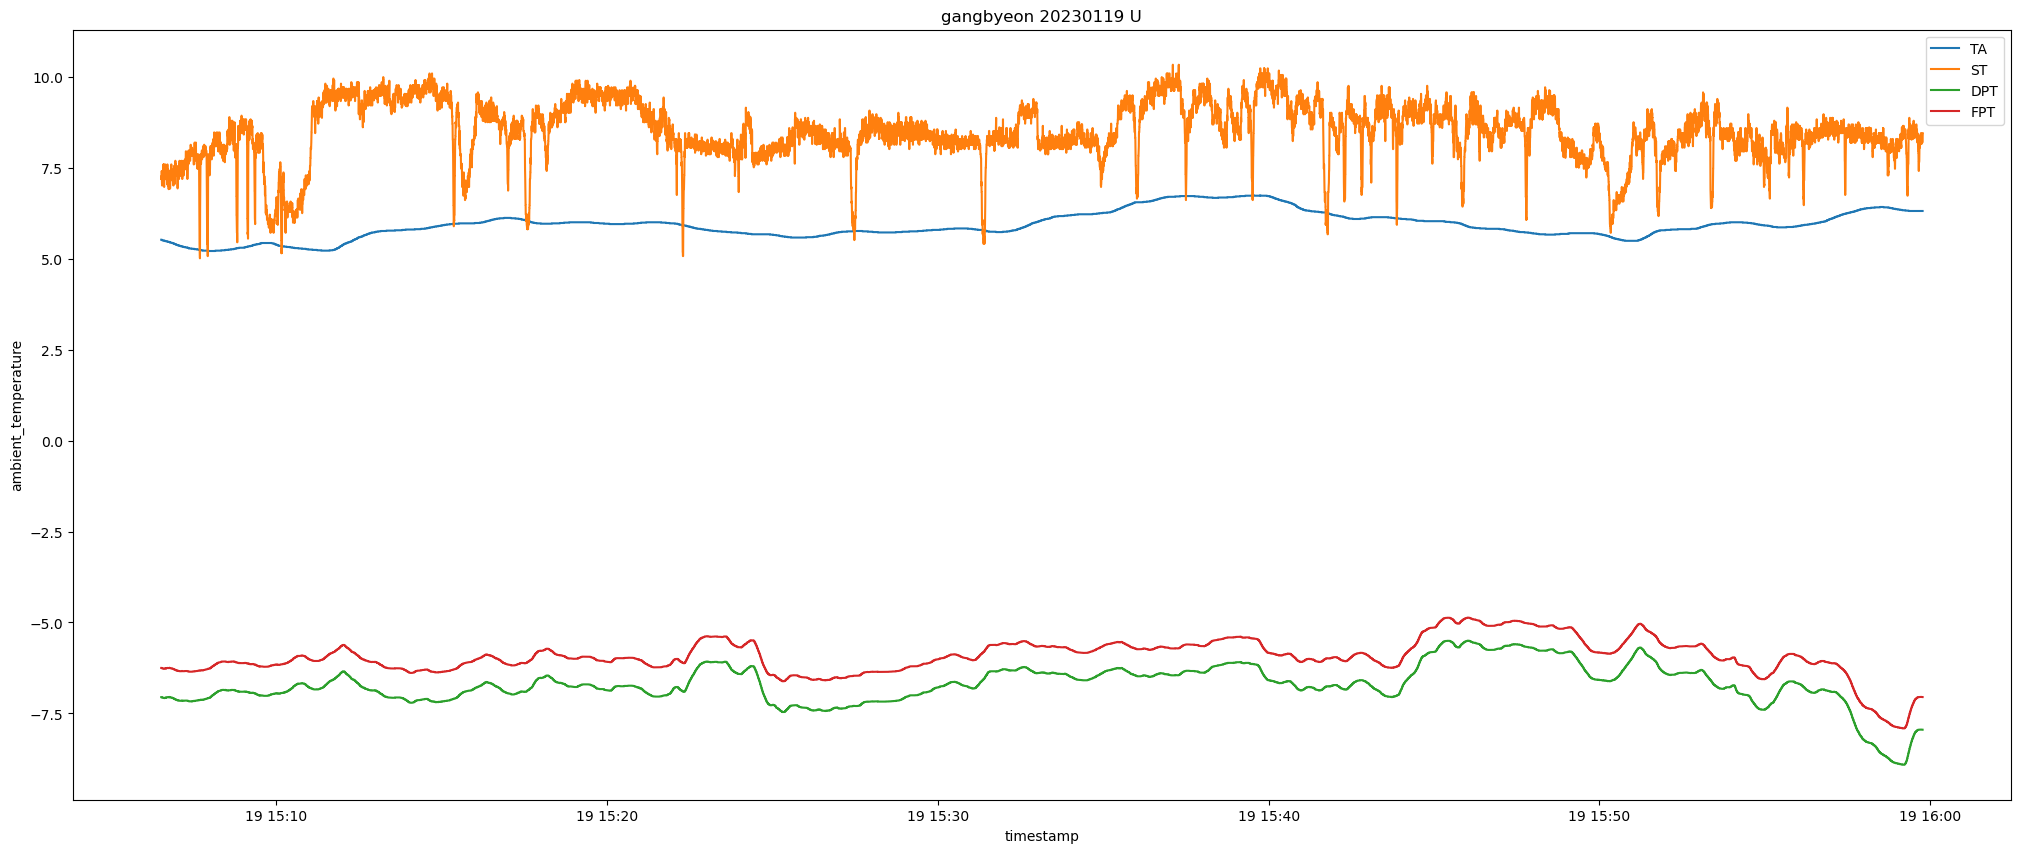

<Figure size 640x480 with 0 Axes>

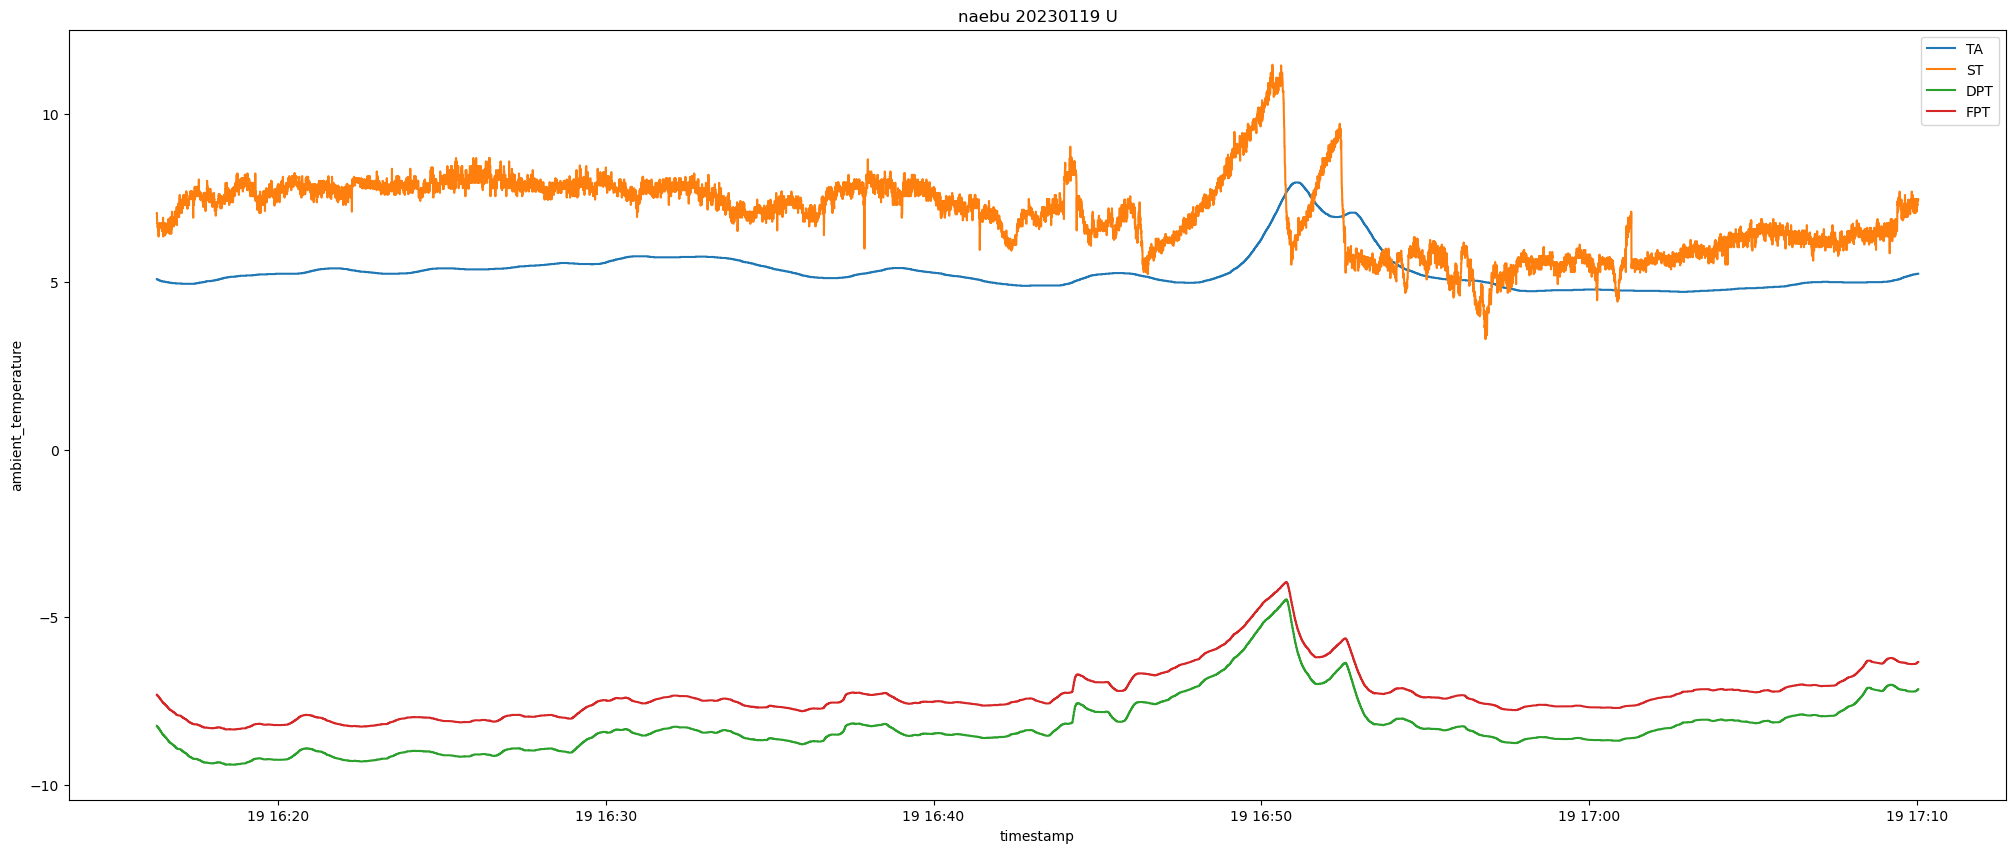

<Figure size 640x480 with 0 Axes>

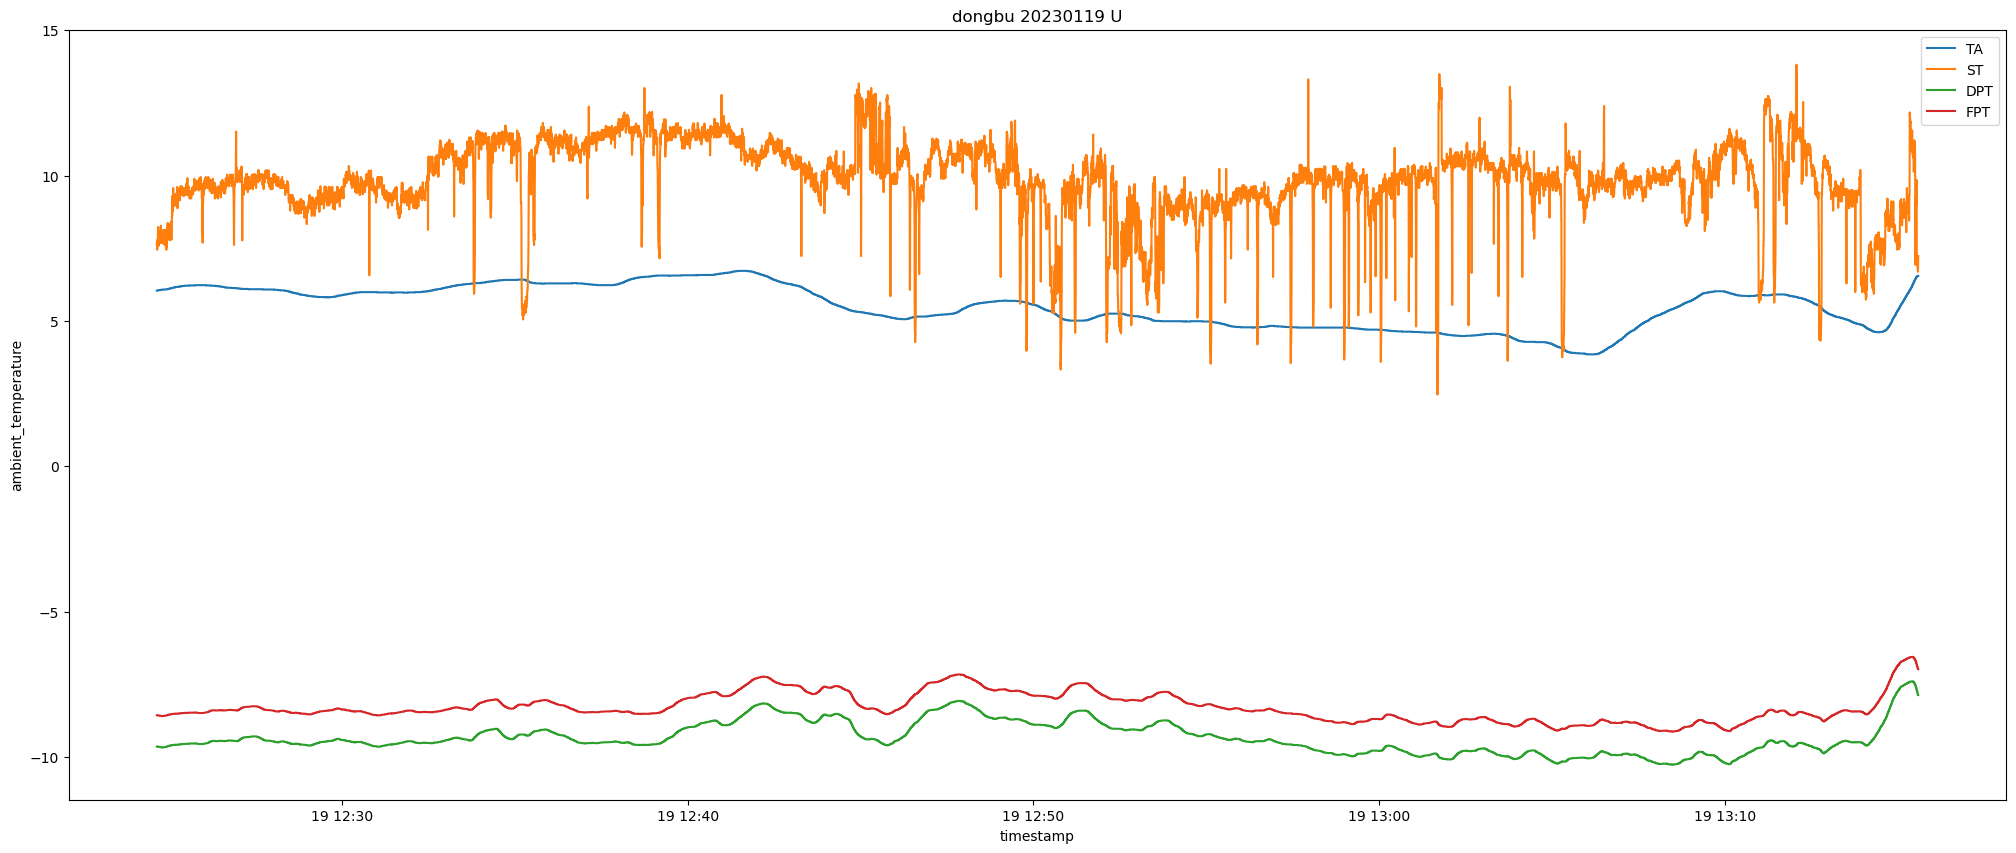

<Figure size 640x480 with 0 Axes>

In [8]:
df_list = glob.glob('../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료/*vaisala*.csv')
for i in df_list:
    df = pd.read_csv(i)

    road_name = i.split('\\')[-1].split('_')[2]
    obs_time = i.split('\\')[-1].split('_')[-2]
    road_dir = i.split('\\')[-1].split('_')[-1].split('.')[0]
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    plt.figure(figsize=(25,10))
    sns.lineplot(data = df , x = 'timestamp',  y = 'ambient_temperature', label = 'TA')
    sns.lineplot(data = df , x = 'timestamp',  y = 'surface_temperature', label = 'ST')
    sns.lineplot(data = df , x = 'timestamp',  y = 'dew_point_temperature', label = 'DPT')
    sns.lineplot(data = df , x = 'timestamp',  y = 'frost_point_temperature', label = 'FPT')
    plt.title(f'{road_name} {obs_time} {road_dir}')
    plt.legend()
    plt.show()
    plt.clf()

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\seoul_3_dongbu_lufft_20230126_D.csv


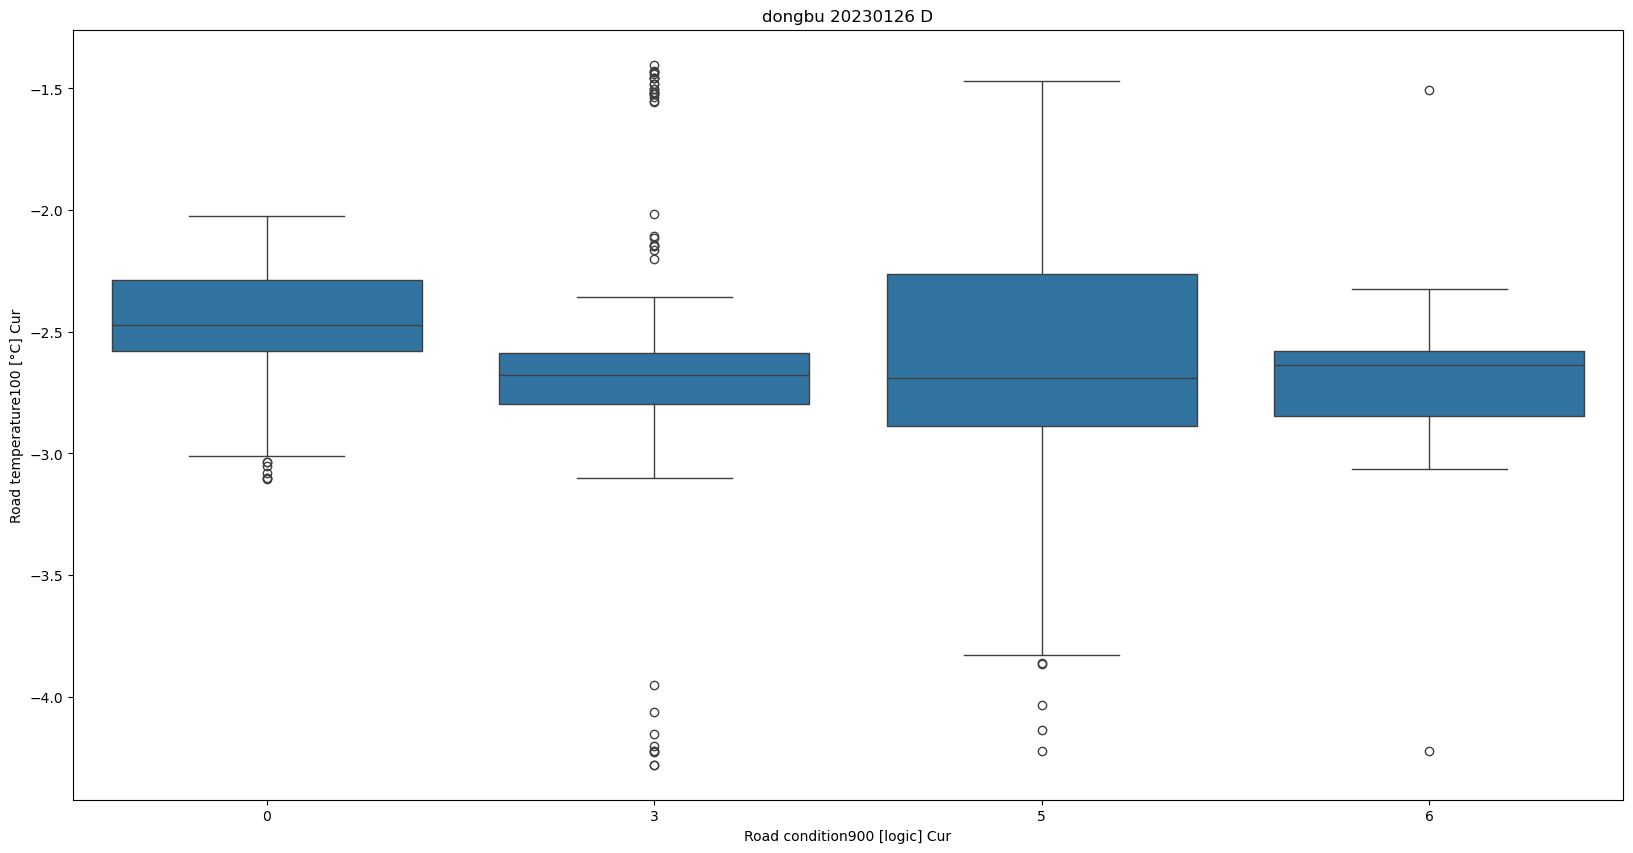

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\seoul_3_dongbu_lufft_20230127_D.csv


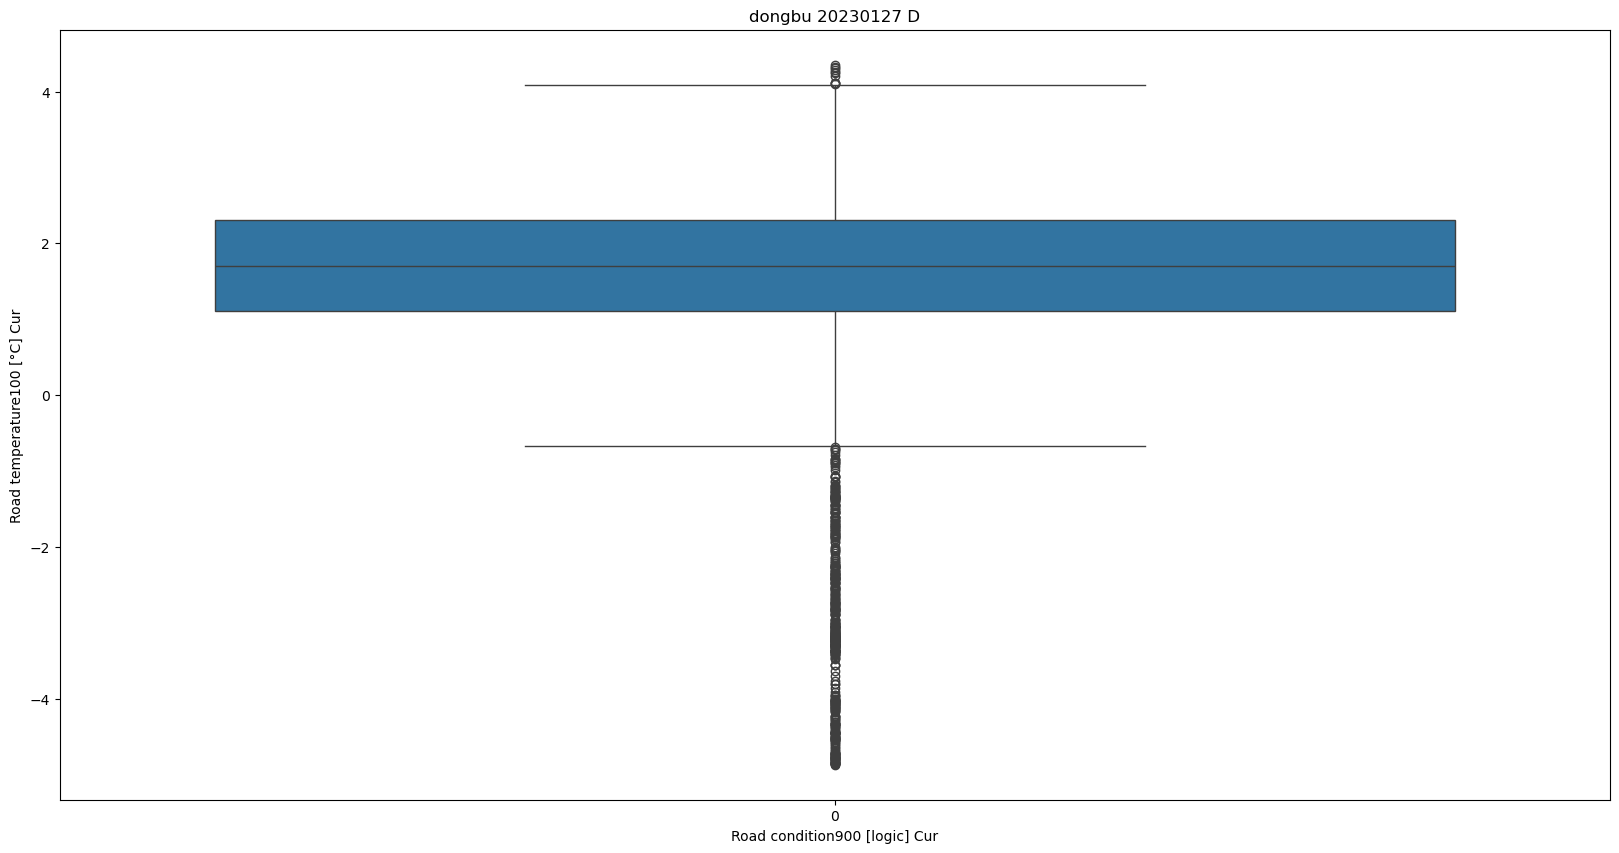

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\seoul_4_seobu_lufft_20230120_D.csv


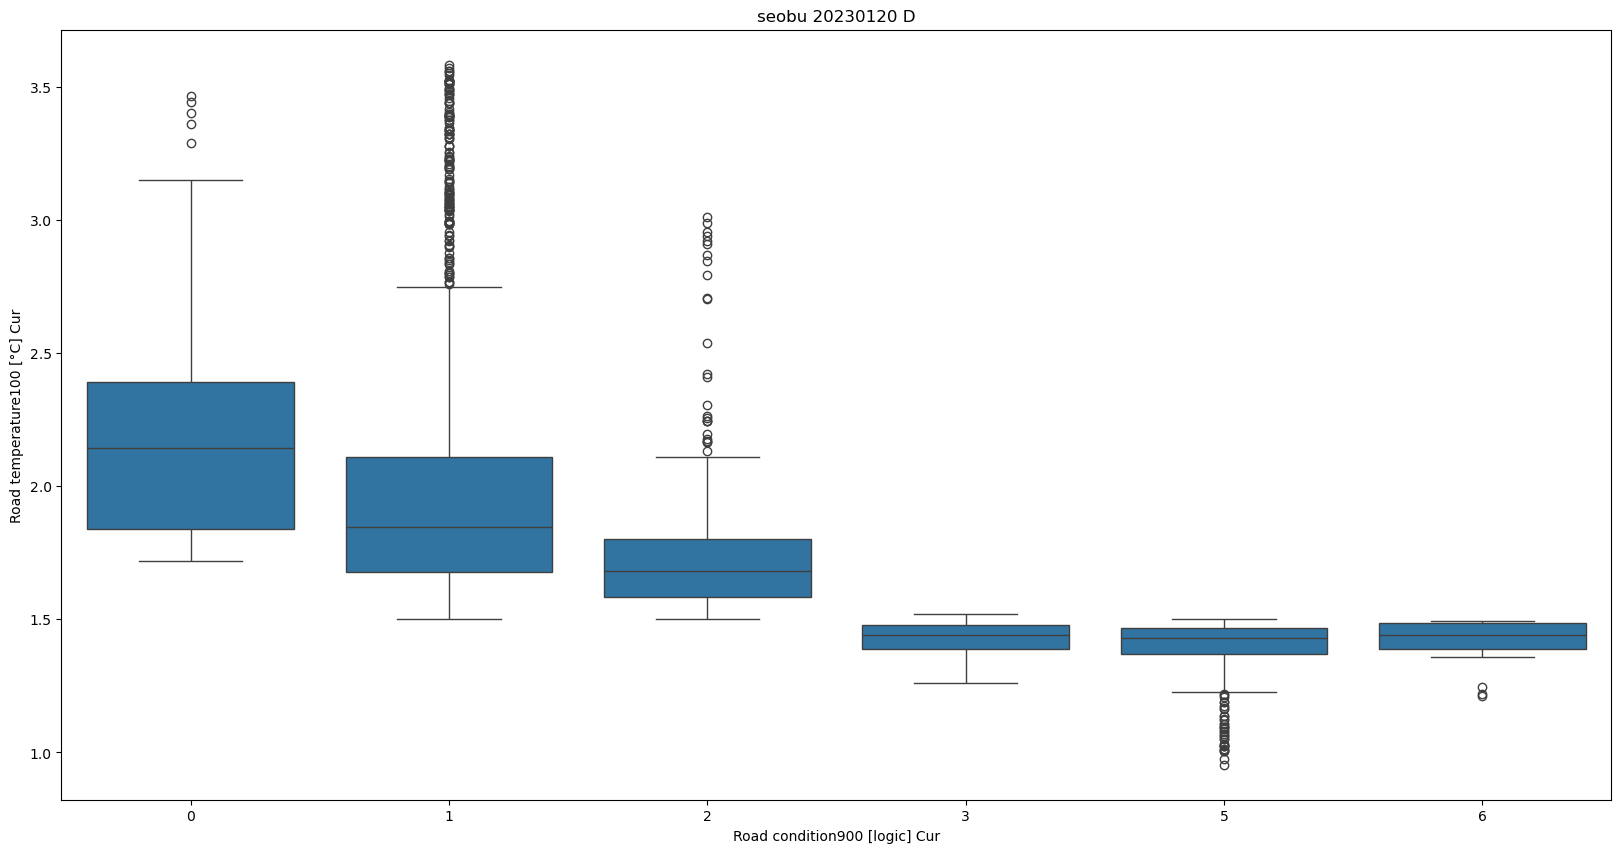

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\seoul_5_olympic_lufft_20230117_U.csv


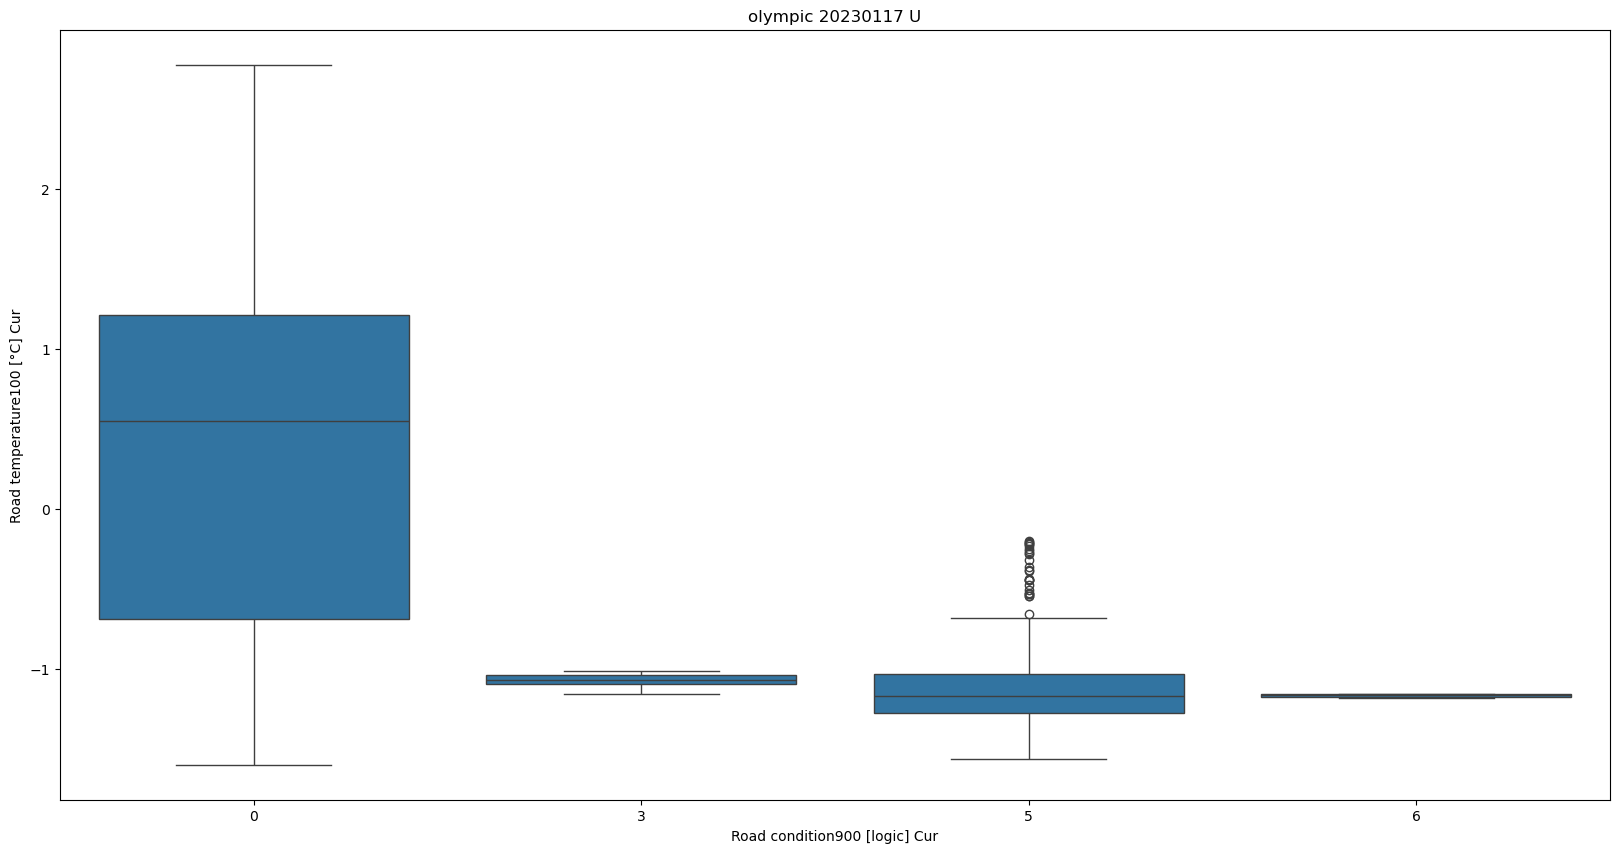

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\seoul_5_olympic_lufft_20230118_U.csv


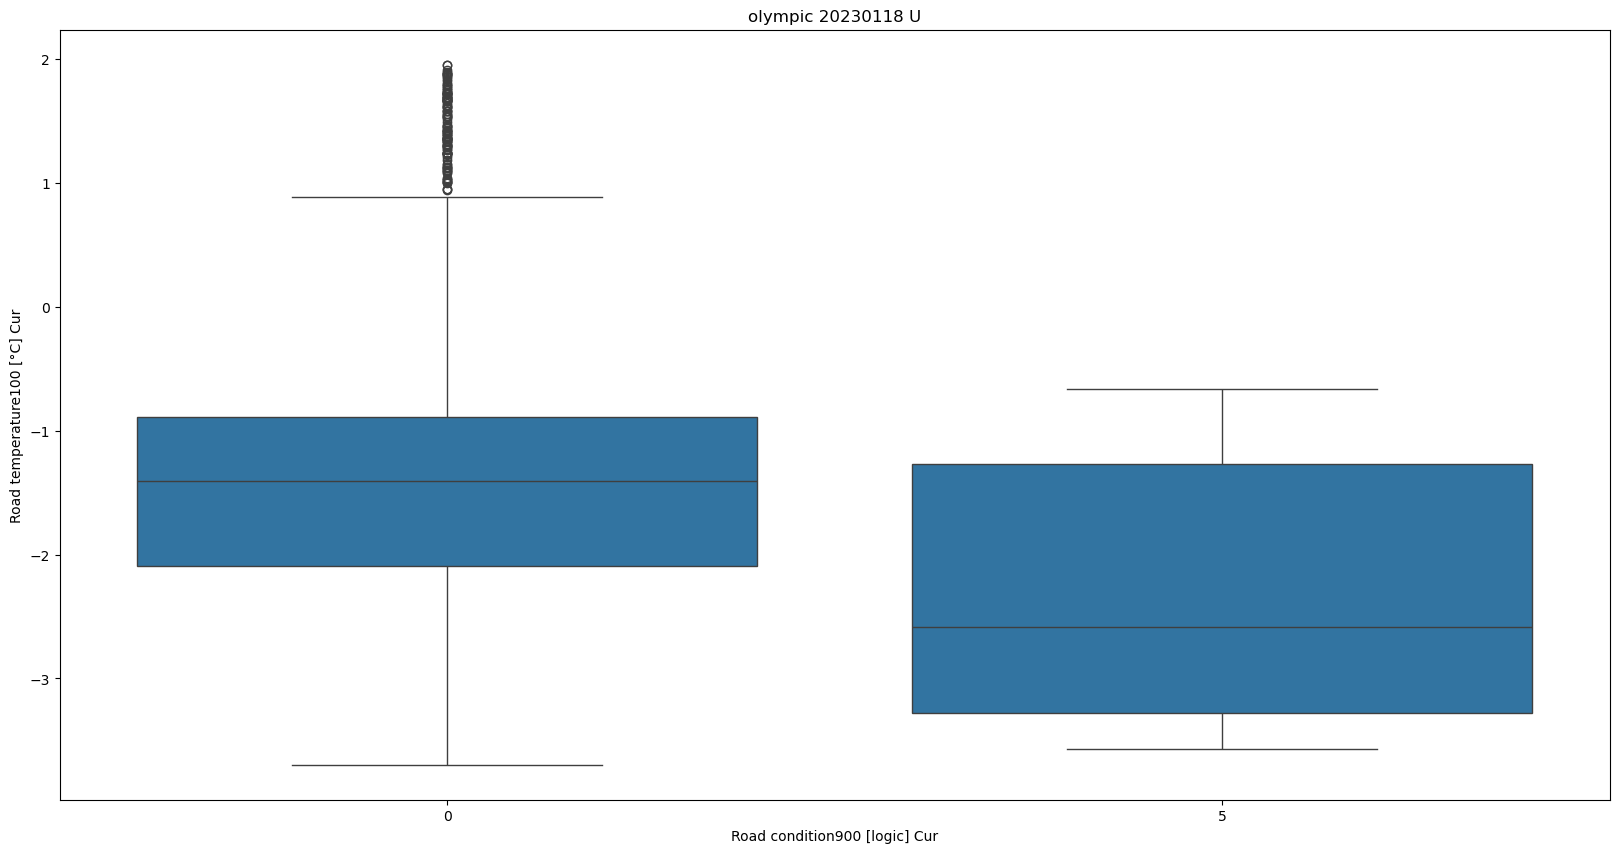

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\seoul_5_olympic_lufft_20230119_U.csv


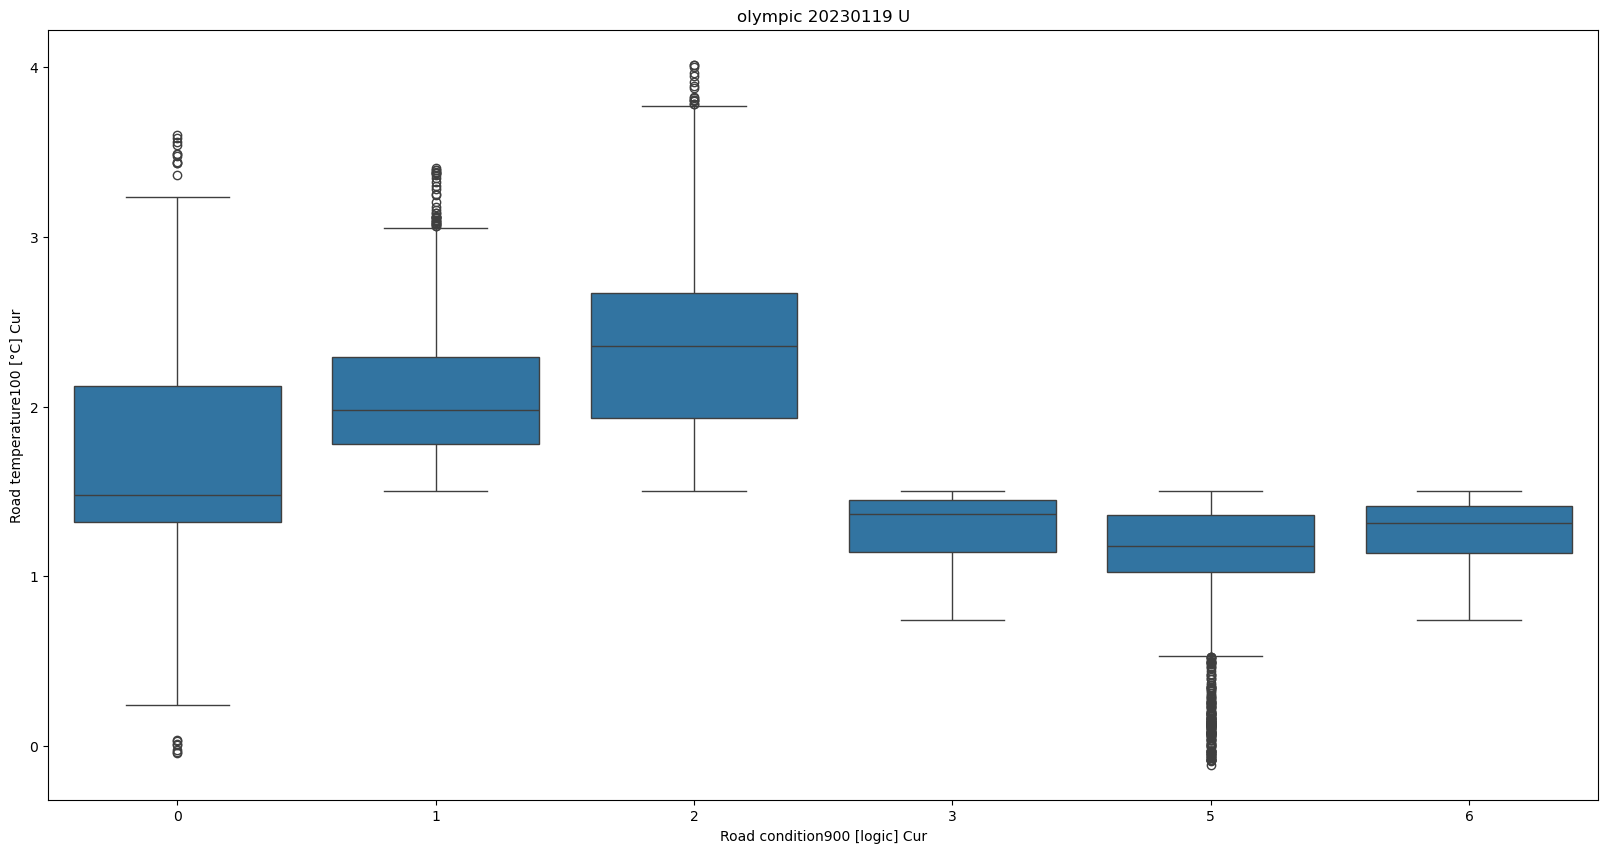

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\seoul_5_olympic_lufft_20230126_D.csv


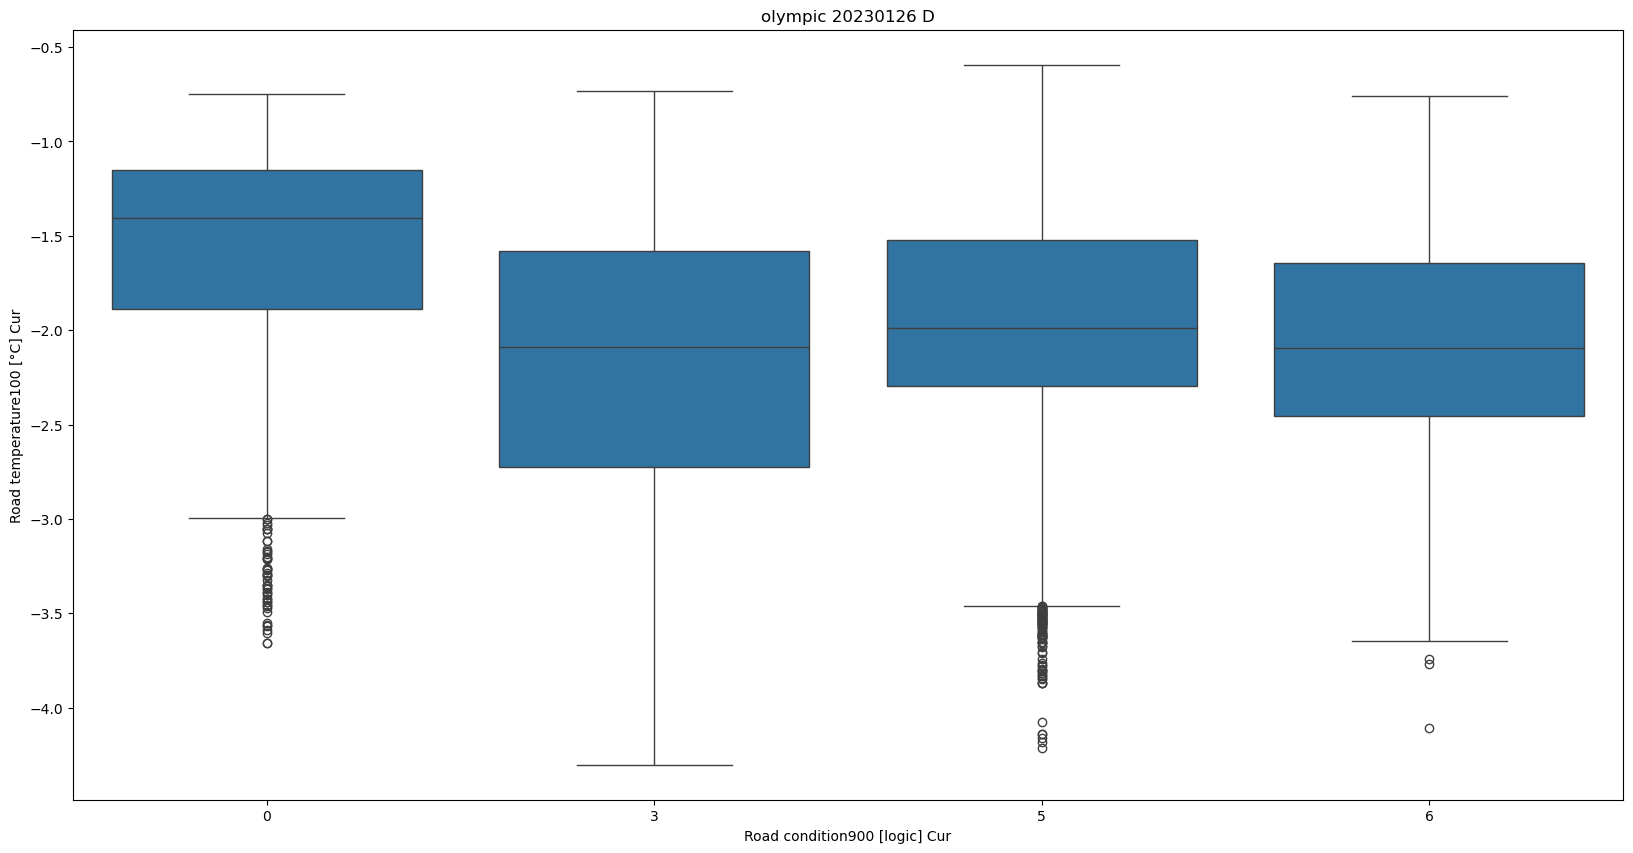

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\seoul_5_olympic_lufft_20230127_D.csv


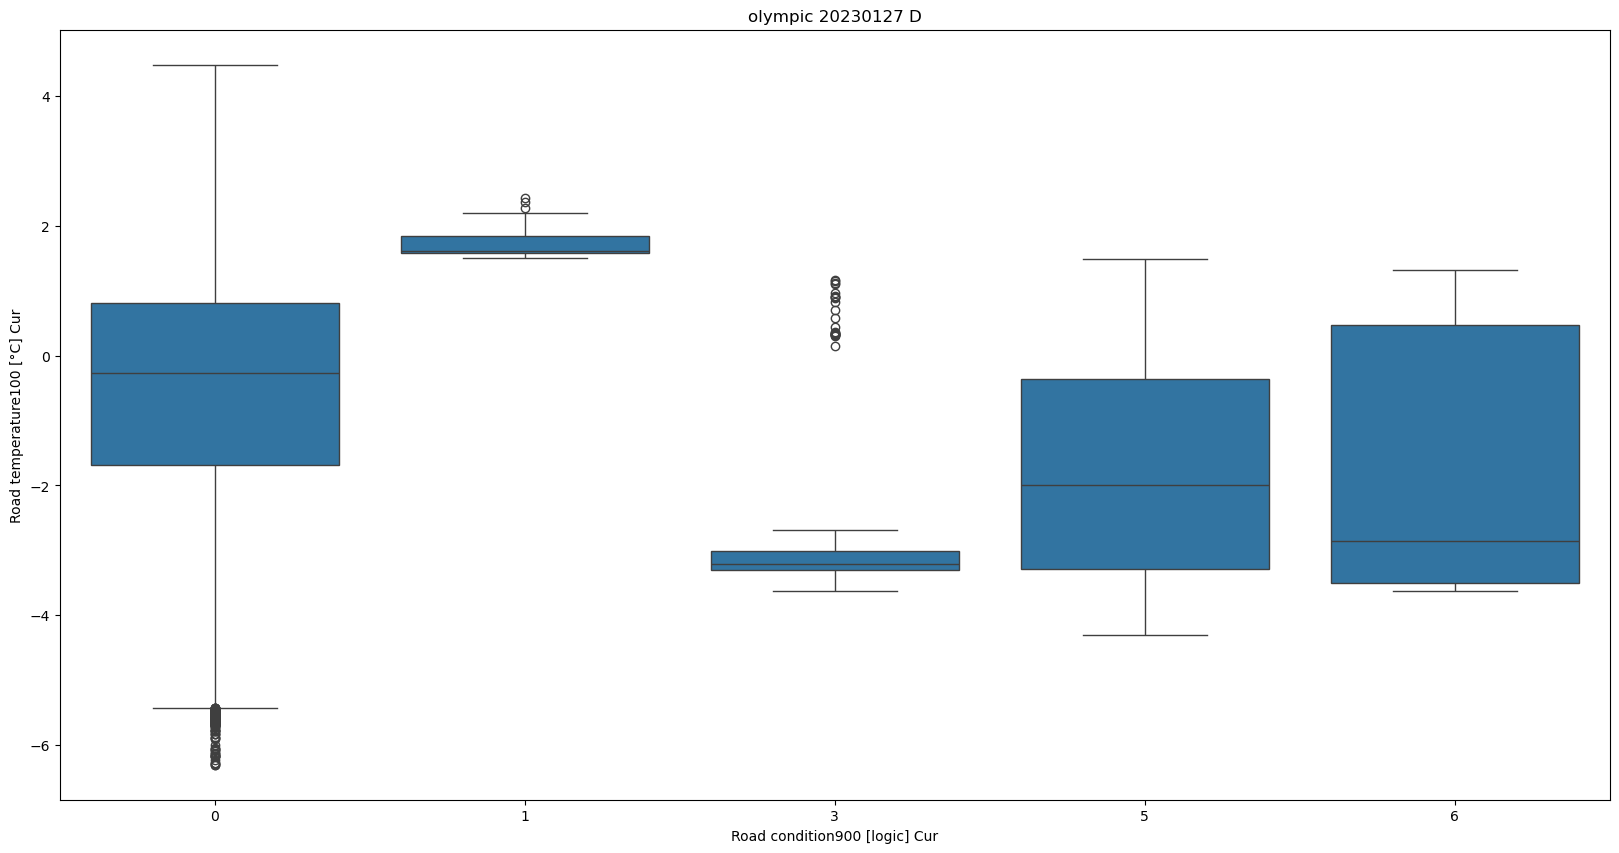

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\sihueng_SHR1_lufft_20230120_D.csv


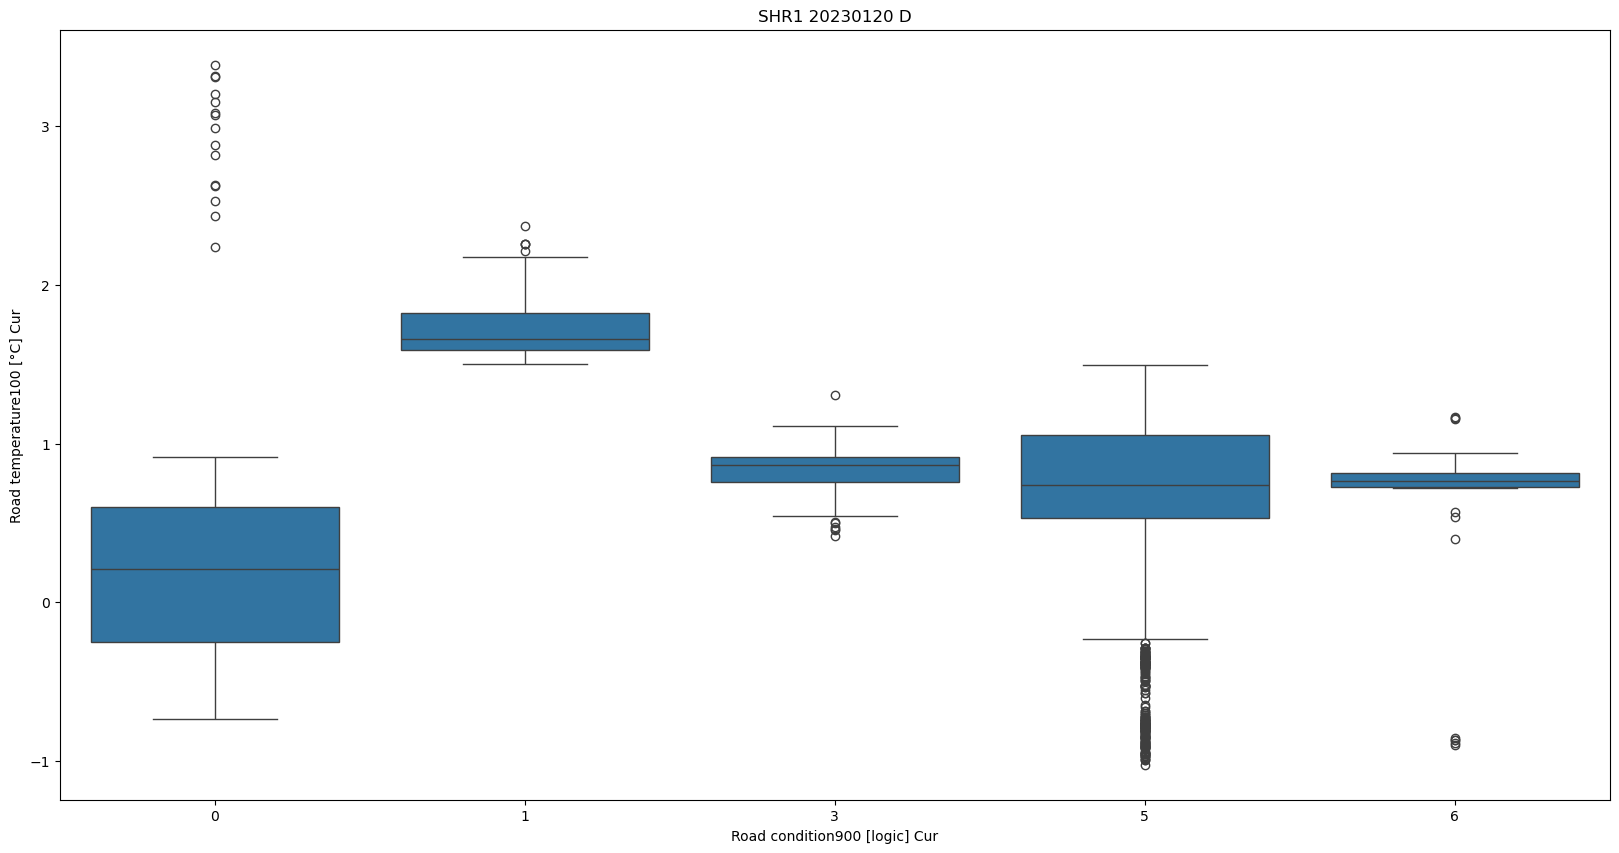

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\sihueng_SHR2_lufft_20230120_U.csv


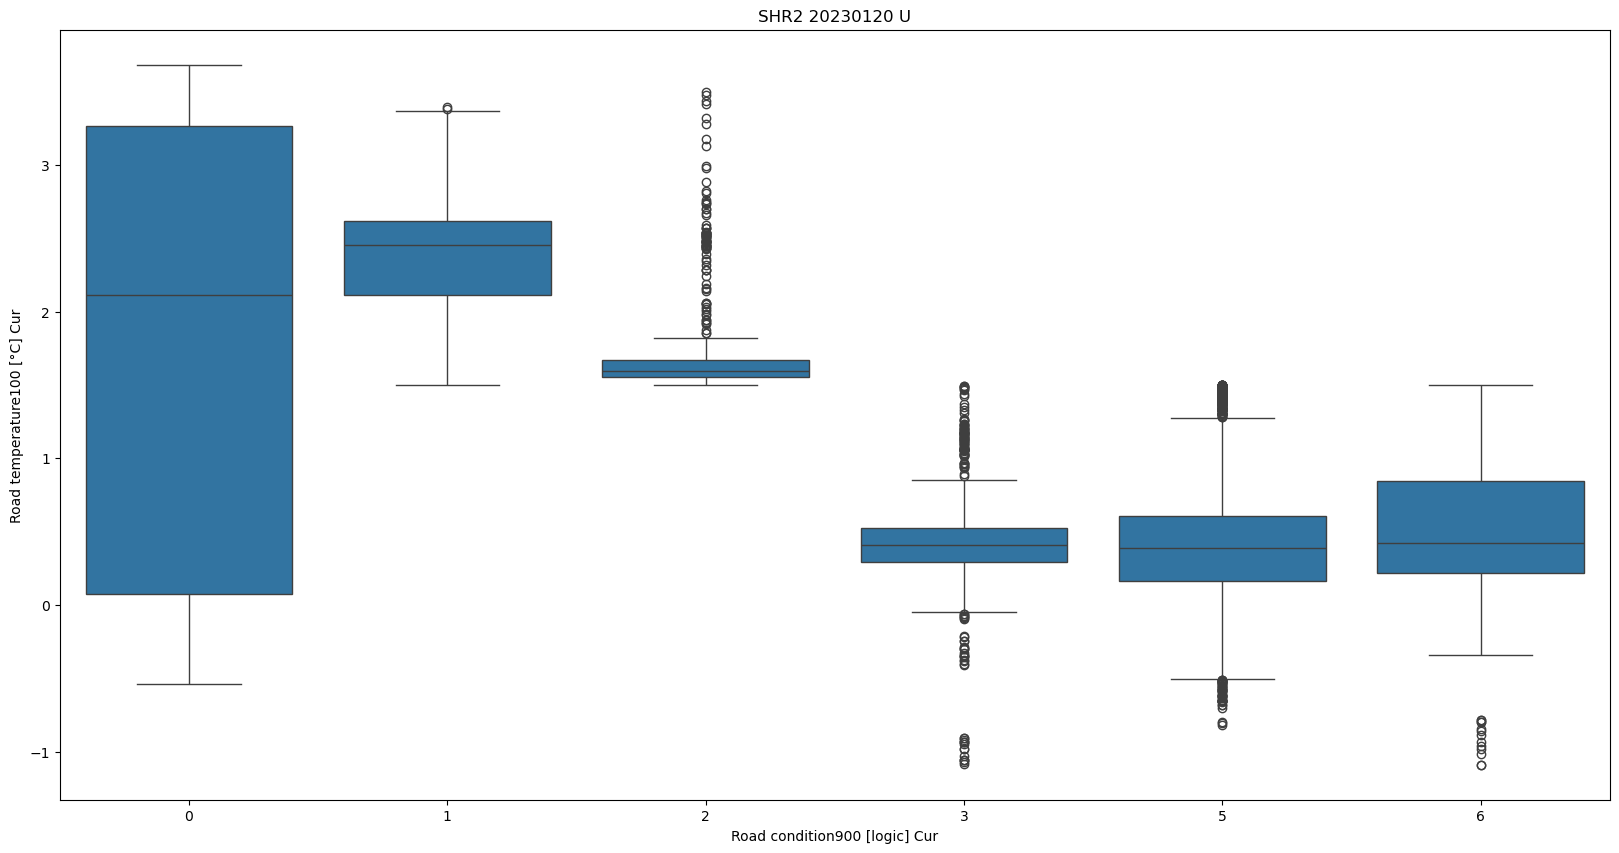

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\sihueng_SHR3_lufft_20230120_D.csv


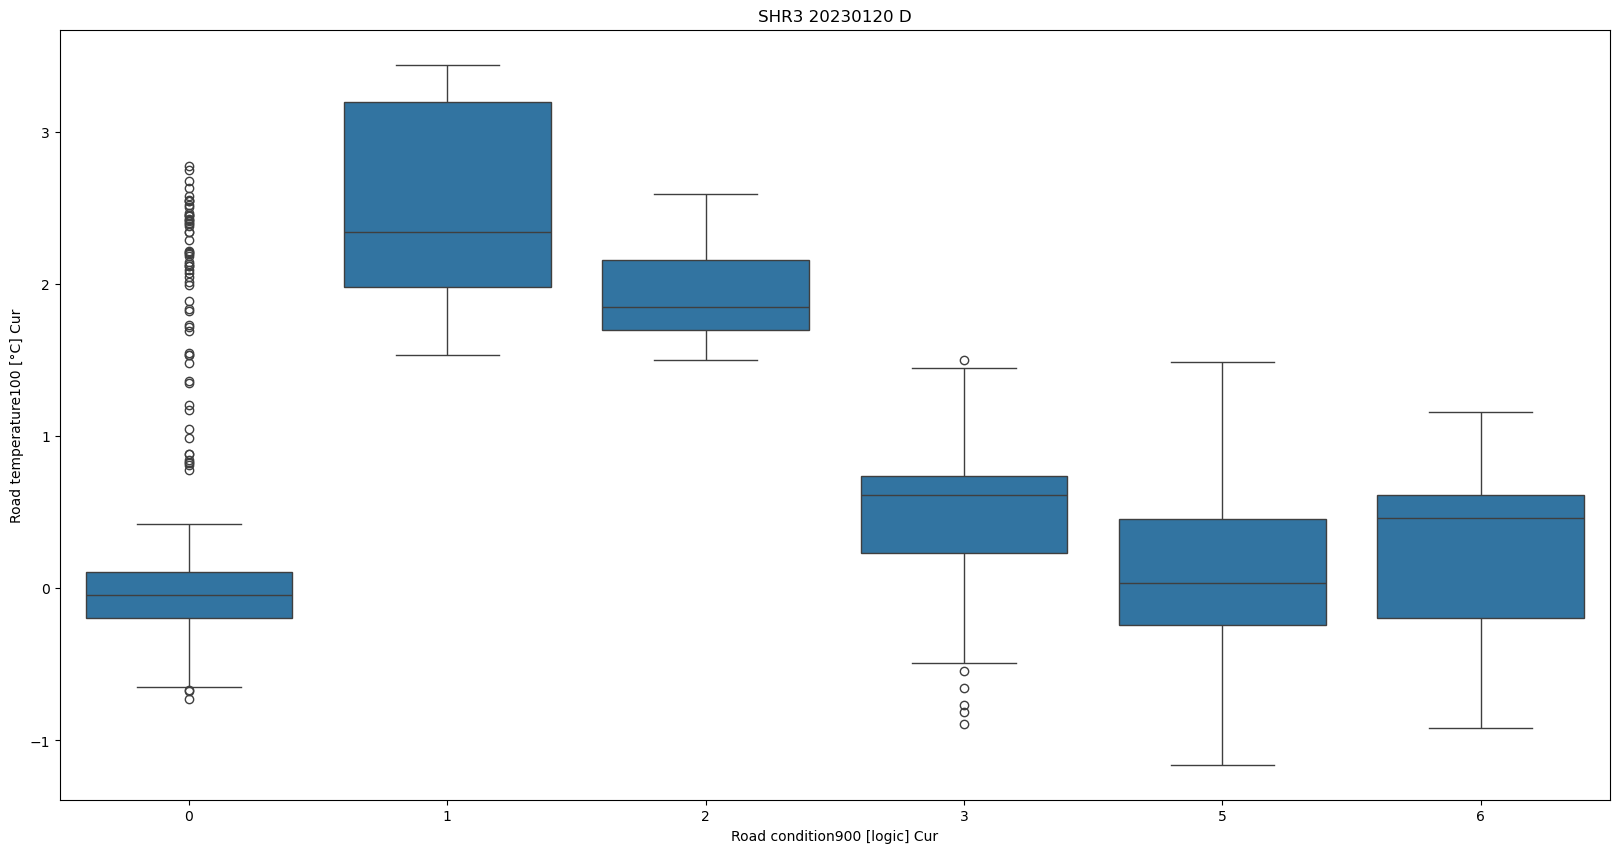

../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료\sihueng_SHR4_lufft_20230120_U.csv


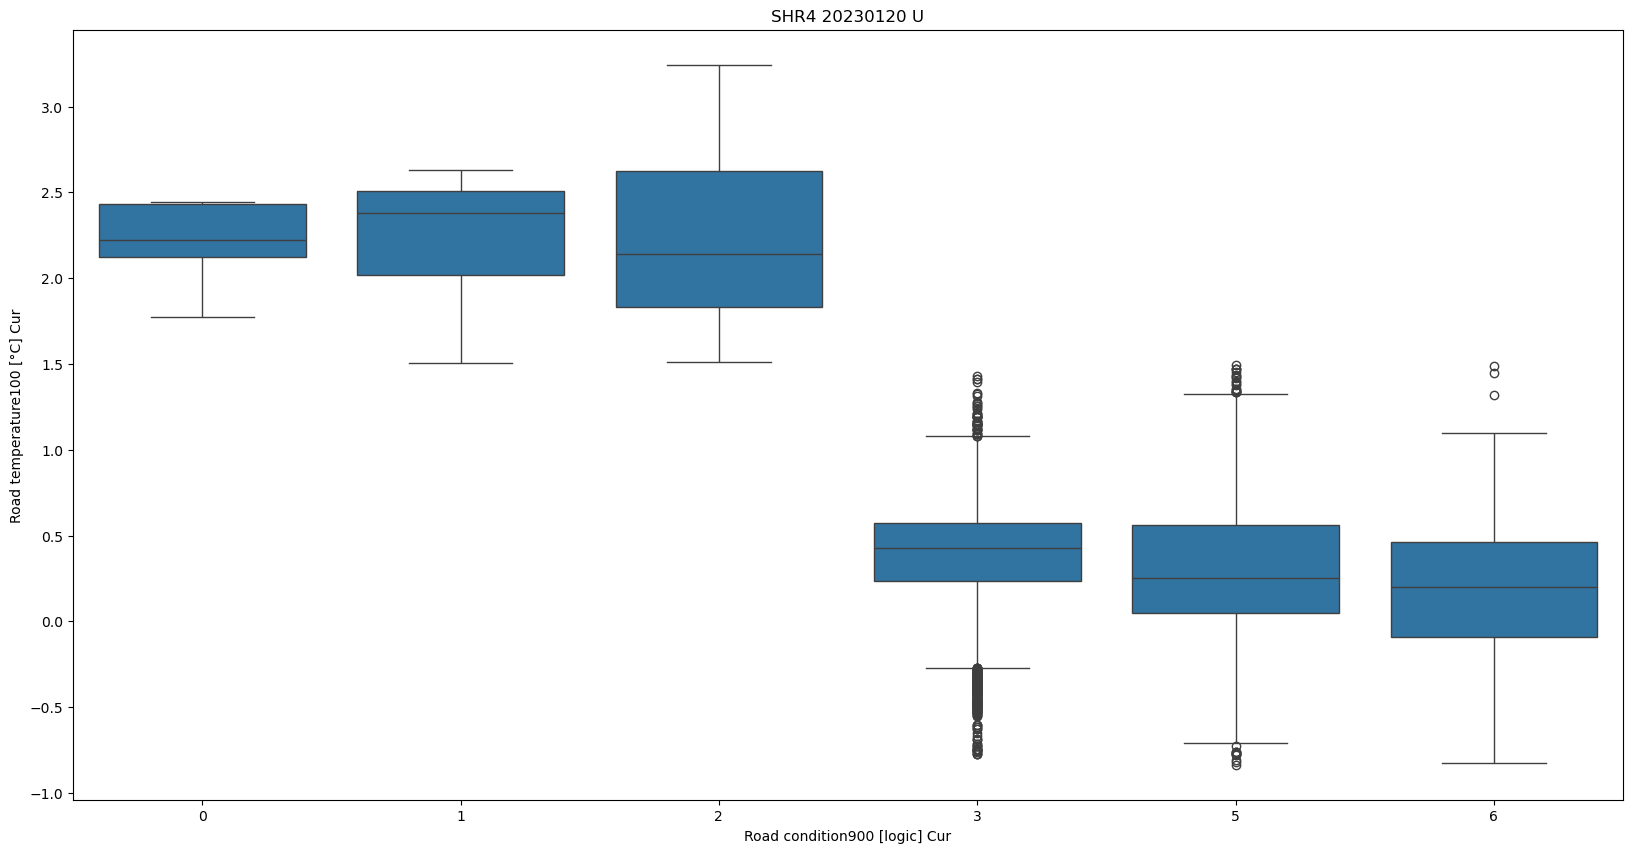

In [ ]:
df_list = glob.glob('../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료/*lufft*.csv')
for i in df_list:
    print(i)
    road_name = i.split('\\')[-1].split('_')[-4]
    obs_time = i.split('\\')[-1].split('_')[-2]
    road_dir = i.split('\\')[-1].split('_')[-1].split('.')[0]
    
    df = pd.read_csv(i)
    plt.figure(figsize=(20,10))
    sns.boxplot(data = df, x = 'Road condition900 [logic] Cur', y = 'Road temperature100 [°C] Cur')
    plt.title(f'{road_name} {obs_time} {road_dir}')
    plt.show()

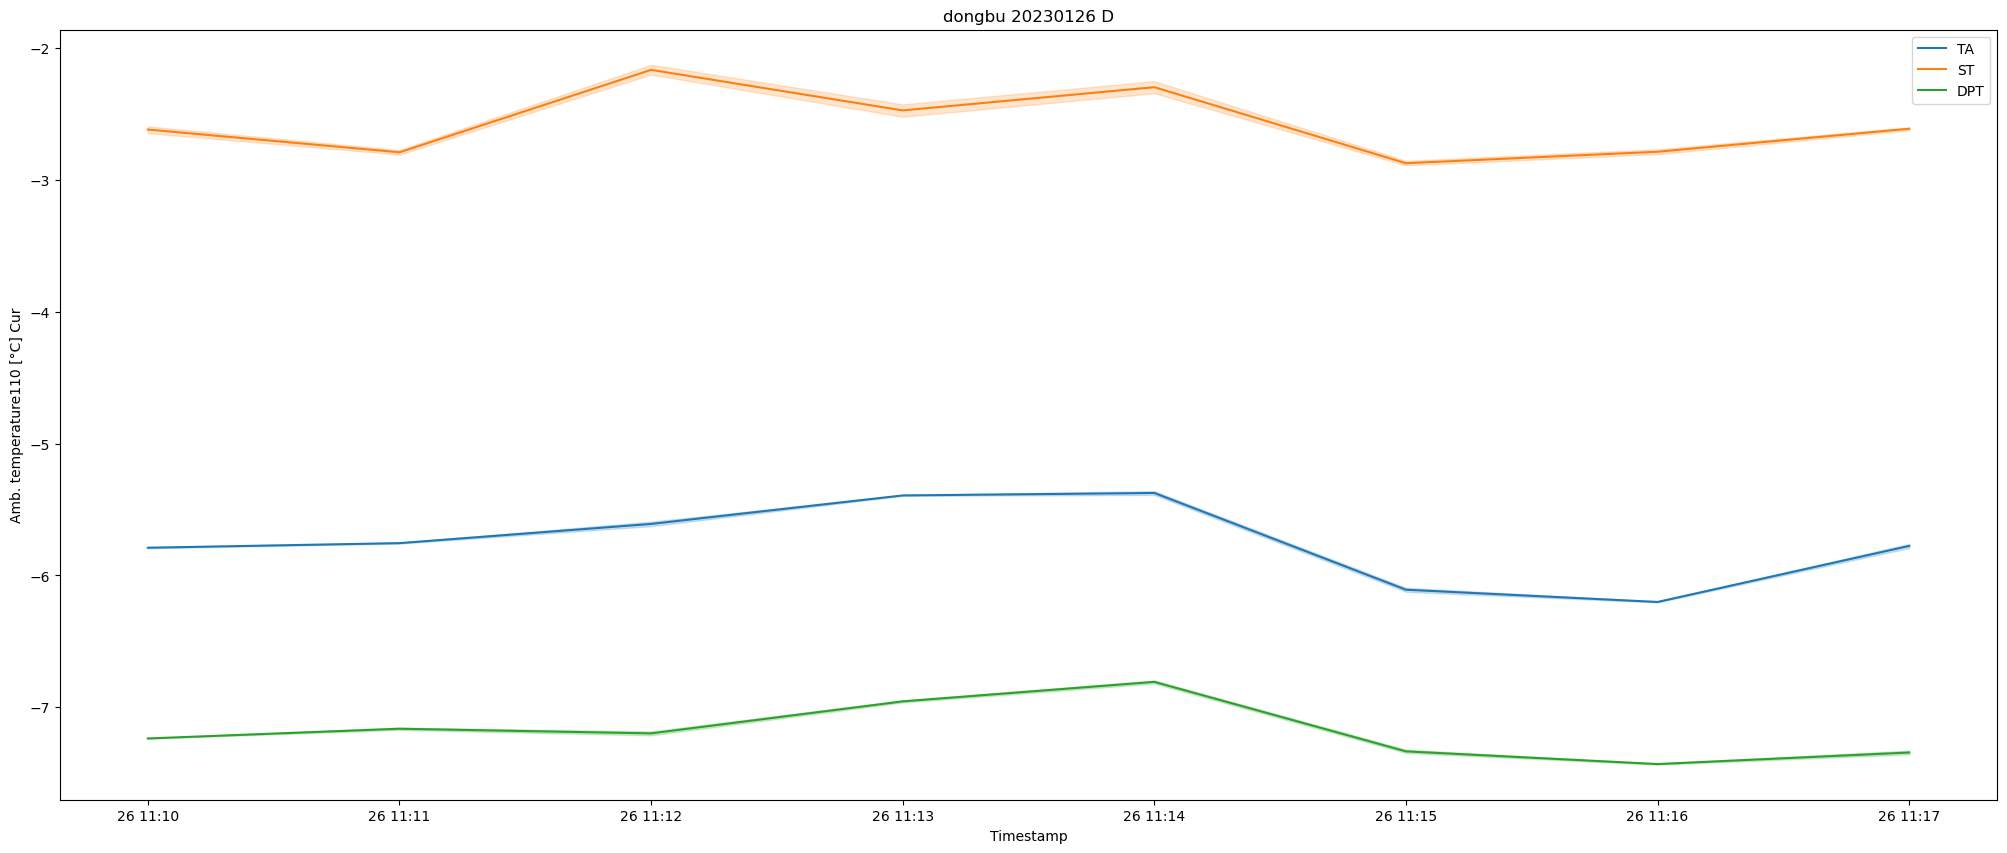

<Figure size 640x480 with 0 Axes>

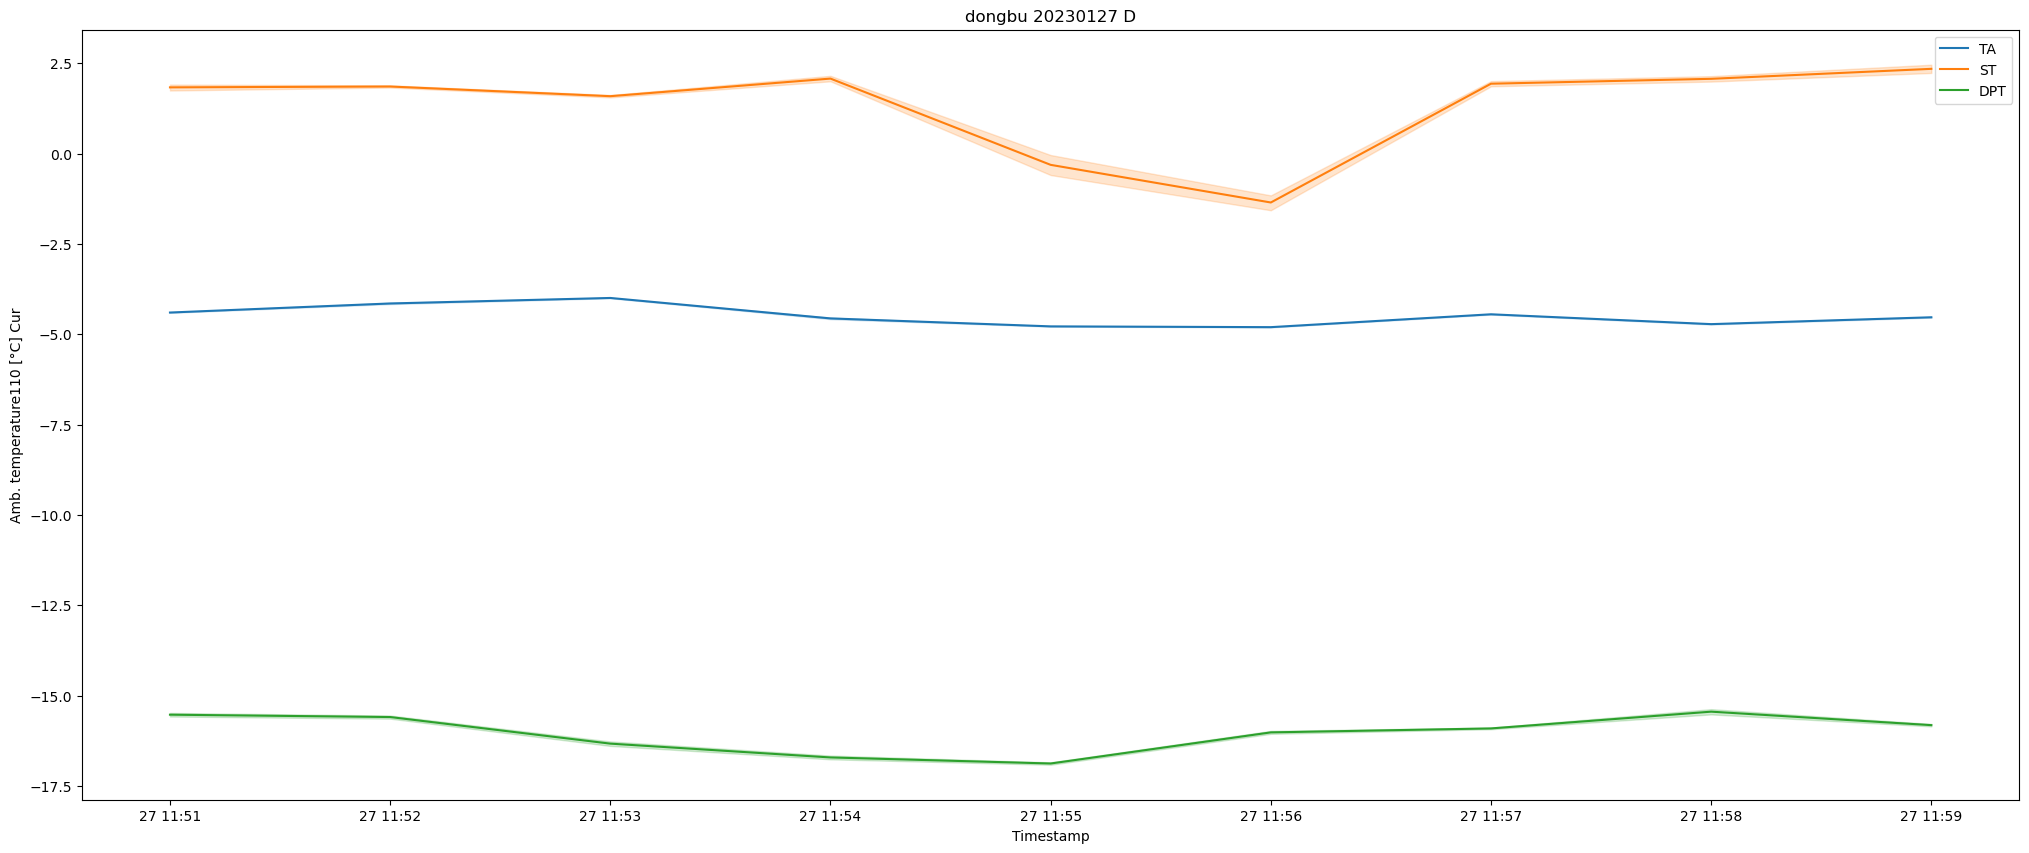

In [ ]:
df_list = glob.glob('../DATA/20230705_스시2_서울&시흥_1월관측_후처리자료/*lufft*.csv')
for i in df_list:
    df = pd.read_csv(i)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    plt.figure(figsize=(25,10))
    road_name = i.split('\\')[-1].split('_')[-4]
    obs_time = i.split('\\')[-1].split('_')[-2]
    road_dir = i.split('\\')[-1].split('_')[-1].split('.')[0]
    plt.title(f'{road_name} {obs_time} {road_dir}')
    sns.lineplot(data = df , x = 'Timestamp',  y = 'Amb. temperature110 [°C] Cur', label = 'TA')
    sns.lineplot(data = df , x = 'Timestamp',  y = 'Road temperature100 [°C] Cur', label = 'ST')
    sns.lineplot(data = df , x = 'Timestamp',  y = 'Dewpoint temperature120 [°C] Cur', label = 'DPT')
    plt.legend()
    plt.show()
    plt.clf()